In [1]:
%pylab inline
import galsim
import numpy as np
import astropy.io.fits as pyfits

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=0, xmax=42, ymin=0, ymax=42), moments_status=0, observed_shape=galsim.Shear((-0.006163288216356356-0.029719278115648496j)), moments_sigma=1.7460271120071411, moments_amp=0.8454300165176392, moments_centroid=galsim.PositionD(x=21.01949990239948, y=20.986712287100985), moments_rho4=2.1641048346462135, moments_n_iter=24, correction_status=-10)


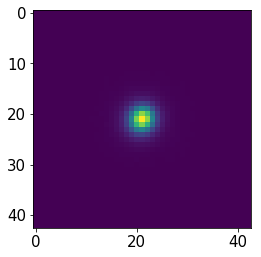

In [3]:
# PSF preparation
ifield=1
psfPre='psfPre'
# Basic parameters
ngrid       =   64
nrot        =   1
nx          =   nrot 
ny          =   1
ndata       =   nx*ny
scale       =   0.16
ngridTot    =   ngrid*nx
bigfft      =   galsim.GSParams(maximum_fft_size=10240)
flux_scaling=   2.587

# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
noiseHead   =   pyfits.getheader(psfFname)
if True:
    psfImg      =   galsim.fits.read(psfFname)
    psfImg.setOrigin(0,0)
    psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
else:
    psfInt      =   galsim.Gaussian(fwhm=0.65,flux=1.)
    psfImg      =   galsim.ImageF(ngrid,ngrid,scale=scale)
    psfImg.setOrigin(0,0)
    psfInt.drawImage(psfImg,offset=(0.5,0.5),method='no_pixel')

# Get the shear information
g1          =   0.02#noiseHead['g1']
g2          =   0.#noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
variance    =   noiseHead['var']
rescale     =   noiseHead['rescale']
ud          =   galsim.UniformDeviate(ifield*10000+1)
np.random.seed(ifield*10000+1)
print(psfImg.FindAdaptiveMom())
plt.imshow(psfImg.array)

In [4]:
# Get the  galaxy generator      
# Load data
tdir=os.path.join(os.environ['homeWrk'],'COSMOS','galsim_train')
Xname='best'
catName     =   'real_galaxy_catalog_%s.fits' %(Xname)
directory   =   os.path.join(tdir,'parent_%s_processed' %(Xname))
rgc         =   galsim.RealGalaxyCatalog(catName,dir=directory)
rgcCat      =   rgc.cat
nrgcDat     =   len(rgcCat)

In [5]:
gals=[]

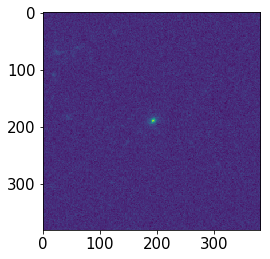

In [6]:
# setup the galaxy image and the noise image
gal_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
gal_image.setOrigin(0,0)
index   =   42
gal0    =   galsim.RealGalaxy(rgc,index=index,gsparams=bigfft)
gal0    *=  flux_scaling
gal0.drawImage(gal_image,offset=(0.5,0.5))
plt.imshow(gal0.original.gal_image.array)
gals.append(gal0.original.gal_image.array)

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=0, xmax=63, ymin=0, ymax=63), moments_status=0, observed_shape=galsim.Shear((0.0027241406796211674-0.04924571032220561j)), moments_sigma=2.201018810272217, moments_amp=19.09157943725586, moments_centroid=galsim.PositionD(x=32.178395498697306, y=31.847110462714973), moments_rho4=2.2068845632048744, moments_n_iter=27, correction_status=-10)


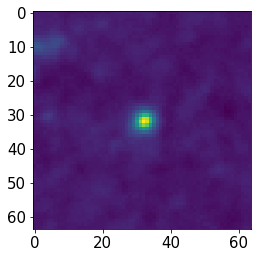

In [7]:
# setup the galaxy image and the noise image
gal_image   =   galsim.ImageF(ngrid,ngrid,scale=scale)
gal_image.setOrigin(0,0)

index   =   42
gal0    =   galsim.RealGalaxy(rgc,index=index,gsparams=bigfft)
gal0    *=  flux_scaling
gal     =   gal0
final   =   gal.shear(g1=g1,g2=g2)
# Shear the galaxy
final   =   galsim.Convolve([psfInt,final],gsparams=bigfft)
# Draw the galaxy image
final.drawImage(gal_image,method='no_pixel',offset=(0.5,0.5))
varHST      =   gal_image.whitenNoise(final.noise)
vn          =   galsim.GaussianNoise(ud,4e-5-varHST)
gal_image.addNoise(vn)
print(gal_image.FindAdaptiveMom())
gals.append(gal_image.array)
plt.imshow(gal_image.array)

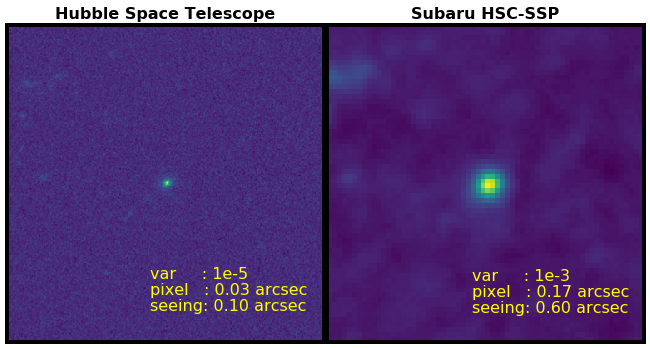

In [41]:
plt.close()
fs=16
figure=plt.figure(figsize=(10,5))
ax=figure.add_subplot(1,2,1)
ax.set_title('Hubble Space Telescope',fontsize=fs,weight='bold')
ax.imshow(gals[0])
ngrid=gals[0].shape[0]
ax.text(0.45*ngrid,0.9*ngrid,'seeing: 0.10 arcsec',color='yellow',fontsize=fs)
ax.text(0.45*ngrid,0.85*ngrid,'pixel   : 0.03 arcsec',color='yellow',fontsize=fs)
ax.text(0.45*ngrid,0.8*ngrid,'var     : 1e-5',color='yellow',fontsize=fs)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for pos in ['top','right','left','bottom']:
    sp=ax.spines[pos]
    sp.set_color('black')
    sp.set_linewidth(4)

ax=figure.add_subplot(1,2,2)
ax.set_title('Subaru HSC-SSP',fontsize=fs,weight='bold')
ax.imshow(gals[1])
ngrid=gals[1].shape[0]
ax.text(0.45*ngrid,0.9*ngrid,'seeing: 0.60 arcsec',color='yellow',fontsize=fs)
ax.text(0.45*ngrid,0.85*ngrid,'pixel   : 0.17 arcsec',color='yellow',fontsize=fs)
ax.text(0.45*ngrid,0.8*ngrid,'var     : 1e-3',color='yellow',fontsize=fs)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for pos in ['top','right','left','bottom']:
    sp=ax.spines[pos]
    sp.set_color('black')
    sp.set_linewidth(4)
#plt.tight_layout()
figure.subplots_adjust(left=0.02,
                bottom=0.02, 
                right=0.98, 
                top=0.90, 
                wspace=-0.14)
figure.savefig('HST2HSC.png')